# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read csv and replace question marks with nans
credit = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', header = None, na_values = "?")

In [165]:
credit.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [166]:
credit[4].value_counts() # checking to make sure there are no question marks

g     519
p     163
gg      2
Name: 4, dtype: int64

In [167]:
credit.shape

(690, 16)

In [168]:
credit.dtypes  # checking what needs to be changed

0      object
1     float64
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10      int64
11     object
12     object
13    float64
14      int64
15     object
dtype: object

In [169]:
pd.to_numeric(credit[1]) # changing string to a number

0      30.83
1      58.67
2      24.50
3      27.83
4      20.17
5      32.08
6      33.17
7      22.92
8      54.42
9      42.50
10     22.08
11     29.92
12     38.25
13     48.08
14     45.83
15     36.67
16     28.25
17     23.25
18     21.83
19     19.17
20     25.00
21     23.25
22     47.75
23     27.42
24     41.17
25     15.83
26     47.00
27     56.58
28     57.42
29     42.08
       ...  
660    22.25
661    29.83
662    23.50
663    32.08
664    31.08
665    31.83
666    21.75
667    17.92
668    30.33
669    51.83
670    47.17
671    25.83
672    50.25
673    29.50
674    37.33
675    41.58
676    30.58
677    19.42
678    17.92
679    20.08
680    19.50
681    27.83
682    17.08
683    36.42
684    40.58
685    21.08
686    22.67
687    25.25
688    17.92
689    35.00
Name: 1, Length: 690, dtype: float64

In [170]:
credit[10] = credit[10].astype('float64')

In [171]:
credit[14] = (credit[14]).astype('float64')

In [172]:
pd.to_numeric(credit[13])  # making sure everything is a float that is supposed to be

0      202.0
1       43.0
2      280.0
3      100.0
4      120.0
5      360.0
6      164.0
7       80.0
8      180.0
9       52.0
10     128.0
11     260.0
12       0.0
13       0.0
14       0.0
15     320.0
16     396.0
17     120.0
18       0.0
19      96.0
20     200.0
21     300.0
22       0.0
23     120.0
24     145.0
25     100.0
26       0.0
27       0.0
28       0.0
29     500.0
       ...  
660      0.0
661    216.0
662    160.0
663    120.0
664    160.0
665      0.0
666    180.0
667     80.0
668    252.0
669    120.0
670    465.0
671      0.0
672    240.0
673    256.0
674    260.0
675    240.0
676    129.0
677    100.0
678      0.0
679      0.0
680    280.0
681    176.0
682    140.0
683    240.0
684    400.0
685    260.0
686    200.0
687    200.0
688    280.0
689      0.0
Name: 13, Length: 690, dtype: float64

In [173]:
# changed column names to give some meaning to the data
credit.columns = ['M/F', 'Hourly Wage', 'Work Experience', 'Type of Work', 'Time Paid', 'Job Abbrev', 'Sub Categ', 'Time at Company', 'Own Home', 'Checking Account', 'Number of Credit Cards', 'Savings Account', 'Credit Rating', 'Savings Account Balance', 'Current Debt', 'Credit Decision']

In [174]:
credit.isnull().sum()  # checking for null values

M/F                        12
Hourly Wage                12
Work Experience             0
Type of Work                6
Time Paid                   6
Job Abbrev                  9
Sub Categ                   9
Time at Company             0
Own Home                    0
Checking Account            0
Number of Credit Cards      0
Savings Account             0
Credit Rating               0
Savings Account Balance    13
Current Debt                0
Credit Decision             0
dtype: int64

In [175]:
credit.replace(np.nan, 0, inplace = True)
credit.isnull().sum()  # changing null values to zero and checking to make sure they are gone

M/F                        0
Hourly Wage                0
Work Experience            0
Type of Work               0
Time Paid                  0
Job Abbrev                 0
Sub Categ                  0
Time at Company            0
Own Home                   0
Checking Account           0
Number of Credit Cards     0
Savings Account            0
Credit Rating              0
Savings Account Balance    0
Current Debt               0
Credit Decision            0
dtype: int64

In [176]:
credit.head()

,M/F,Hourly Wage,Work Experience,Type of Work,Time Paid,Job Abbrev,Sub Categ,Time at Company,Own Home,Checking Account,Number of Credit Cards,Savings Account,Credit Rating,Savings Account Balance,Current Debt,Credit Decision
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,202.0,0.0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,43.0,560.0,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,280.0,824.0,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,100.0,3.0,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,120.0,0.0,+


## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

In [177]:
from scipy import stats
from scipy.stats import kruskal

In [178]:
# replacing booleans with numbers for computation
credit["M/F_value"] = credit["M/F"].replace({'a': 1, 'b' : 0})
credit['Own Home_value'] = credit['Own Home'].replace({'t': 1, 'f' : 0})
credit['Checking Account_value'] = credit['Checking Account'].replace({'t': 1, 'f' : 0})
credit['Savings Account_value'] = credit['Savings Account'].replace({'t': 1, 'f' : 0})
credit['Credit Decision_value'] = credit['Credit Decision'].replace({'+': 1, '-' : 0})

In [179]:
credit.head()

,M/F,Hourly Wage,Work Experience,Type of Work,Time Paid,Job Abbrev,Sub Categ,Time at Company,Own Home,Checking Account,...,Savings Account,Credit Rating,Savings Account Balance,Current Debt,Credit Decision,M/F_value,Own Home_value,Checking Account_value,Savings Account_value,Credit Decision_value
0,b,30.83,0.000,u,g,w,v,1.25,t,t,...,f,g,202.0,0.0,+,0,1,1,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,...,f,g,43.0,560.0,+,1,1,1,0,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,...,f,g,280.0,824.0,+,1,1,0,0,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,...,t,g,100.0,3.0,+,0,1,1,1,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,...,f,s,120.0,0.0,+,0,1,0,0,1


In [180]:
credit.describe()  # getting basic statistics for the dataframe

,Hourly Wage,Work Experience,Time at Company,Number of Credit Cards,Savings Account Balance,Current Debt,M/F_value,Own Home_value,Checking Account_value,Savings Account_value,Credit Decision_value
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,31.019159,4.758725,2.223406,2.40000,180.547826,1017.385507,0.304348,0.523188,0.427536,0.457971,0.444928
std,12.552078,4.978163,3.346513,4.86294,173.970323,5210.102598,0.460464,0.499824,0.495080,0.498592,0.497318
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.440000,1.000000,0.165000,0.00000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.170000,2.750000,1.000000,0.00000,160.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,37.707500,7.207500,2.625000,3.00000,272.000000,395.500000,1.000000,1.000000,1.000000,1.000000,1.000000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [181]:
def confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
    stderr = stats.sem(data)
    interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
    return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
    location = "Our mean lies within the interval ]{:.2}, {:.2}[".format(
    confidence_interval[1], confidence_interval[2])
    return location

credit_decision = confidence_interval(credit['Credit Decision_value'])
print(credit_decision)
people = report_confidence_interval(credit_decision)
print(people)

#Checking to make sure I have the right mean for Credit Decision

(0.4449275362318841, 0.4077550562977503, 0.4821000161660179)
Our mean lies within the interval ]0.41, 0.48[


In [182]:
import scipy
from scipy import stats
Underscore = "\x1b[4m"
End = '\033[0m'
print("\033[1;34;48m   ================ T-Test for M/F and Credit Decision ===============\033", End)
print(scipy.stats.ttest_ind(credit["M/F_value"], credit['Credit Decision_value']), "\n")
print("\033[1;34;48m ============ T-Test for Owning a Home and Credit Decision ============\033", End)
print(scipy.stats.ttest_ind(credit["Own Home_value"], credit['Credit Decision_value']), "\n")
print("\033[1;34;48m ====== T-Test for Checking Account Status and Credit Decision =======\033", End)
print(scipy.stats.ttest_ind(credit["Checking Account_value"], credit['Credit Decision_value']), "\n")
print("\033[1;34;48m ======== T-Test for Savings Account Status and Credit Decision ======== \033", End)
print(scipy.stats.ttest_ind(credit["Savings Account_value"], credit['Credit Decision_value']), "\n")

# two sided t-tests

   ================ T-Test for M/F and Credit Decision =============== 
Ttest_indResult(statistic=-5.448461921708912, pvalue=6.0109701866229e-08) 

 ============ T-Test for Owning a Home and Credit Decision ============ 
Ttest_indResult(statistic=2.9155840617251676, pvalue=0.003607646279018327) 

 ====== T-Test for Checking Account Status and Credit Decision ======= 
Ttest_indResult(statistic=-0.6510053905997015, pvalue=0.515151545023733) 

 ======== T-Test for Savings Account Status and Credit Decision ========  
Ttest_indResult(statistic=0.48653316953392756, pvalue=0.6266665620317966) 



In [183]:
credit["M/F"] = credit["M/F"].replace({'a': 'Male', 'b' : 'Female'})
credit['Own Home'] = credit['Own Home'].replace({'t': 'Yes', 'f' : 'No'})
credit['Checking Account'] = credit['Checking Account'].replace({'t': 'Yes', 'f' : 'No'})
credit['Savings Account'] = credit['Savings Account'].replace({'t': 'Yes', 'f' : 'No'})
credit['Credit Decision'] = credit['Credit Decision'].replace({'+': 'Receives Credit', '-' : 'Rejected for Credit'})

In [184]:
# Using crosstabs for my data
data = pd.crosstab(credit['Own Home'], [credit['Credit Decision']])
data1 = pd.crosstab(credit["M/F"], credit['Credit Decision'])
data2 = pd.crosstab(credit['Checking Account'], credit['Credit Decision'])
data3 = pd.crosstab(credit['Savings Account'], credit['Credit Decision'])
print(data, "\n", "\n", data1, "\n", "\n", data2, "\n", "\n", data3)


Credit Decision  Receives Credit  Rejected for Credit
Own Home                                             
No                            23                  306
Yes                          284                   77 
 
 Credit Decision  Receives Credit  Rejected for Credit
M/F                                                  
0                              3                    9
Female                       206                  262
Male                          98                  112 
 
 Credit Decision   Receives Credit  Rejected for Credit
Checking Account                                      
No                             98                  297
Yes                           209                   86 
 
 Credit Decision  Receives Credit  Rejected for Credit
Savings Account                                      
No                           161                  213
Yes                          146                  170


In [185]:
decision = credit.groupby('Credit Decision').mean()
decision = decision.T # Much easier format to deal with
decision

Credit Decision,Receives Credit,Rejected for Credit
Hourly Wage,33.500814,29.029948
Work Experience,5.904951,3.839948
Time at Company,3.427899,1.257924
Number of Credit Cards,4.605863,0.631854
Savings Account Balance,161.208469,196.049608
Current Debt,2038.859935,198.605744
M/F_value,0.319218,0.292428
Own Home_value,0.925081,0.201044
Checking Account_value,0.680782,0.224543
Savings Account_value,0.475570,0.443864


In [186]:
credit_decision = pd.crosstab(credit['Credit Decision'], [credit['M/F_value'], credit['Hourly Wage'], credit['Work Experience'], credit['Time at Company'], credit['Own Home_value'], credit['Checking Account_value'], credit['Number of Credit Cards'], credit['Savings Account_value'], credit['Savings Account Balance'], credit['Current Debt']])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(credit_decision)
print("\033[1;34;48m ===Chi2 Stat===\033", End)
print(chi2_stat)
print("\n")
print("\033[1;34;48m ===Degrees of Freedom===\033", End)
print(dof)
print("\n")
print("\033[1;34;48m ===P-Value===\033", End)
print(p_val)
print("\n")
print("\033[1;34;48m===Contingency Table===\033", End)
print(ex)

 ===Chi2 Stat=== 
689.9999999999999


 ===Degrees of Freedom=== 
689


 ===P-Value=== 
0.4820999783240398


===Contingency Table=== 
[[0.44492754 0.44492754 0.44492754 ... 0.44492754 0.44492754 0.44492754]
 [0.55507246 0.55507246 0.55507246 ... 0.55507246 0.55507246 0.55507246]]


In [187]:
gender = pd.crosstab(credit['Credit Decision'], [credit['M/F_value']])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(gender)
print("\033[1;34;48m ===Chi2 Stat===\033", End)
print(chi2_stat)
print("\n")
print("\033[1;34;48m ===Degrees of Freedom===\033", End)
print(dof)
print("\n")
print("\033[1;34;48m ===P-Value===\033", End)
print(p_val)
print("\n")
print("\033[1;34;48m===Contingency Table===\033", End)
print(ex)

 ===Chi2 Stat=== 
0.45805448554005934


 ===Degrees of Freedom=== 
1


 ===P-Value=== 
0.49853461823239953


===Contingency Table=== 
[[213.56521739  93.43478261]
 [266.43478261 116.56521739]]


In [188]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(data)
print("\033[1;34;48m ===Chi2 Stat===\033", End)
print(chi2_stat)
print("\n")
print("\033[1;34;48m ===Degrees of Freedom===\033", End)
print(dof)
print("\n")
print("\033[1;34;48m ===P-Value===\033", End)
print(p_val)
print("\n")
print("\033[1;34;48m===Contingency Table===\033", End)
print(ex)

 ===Chi2 Stat=== 
355.2038167412799


 ===Degrees of Freedom=== 
1


 ===P-Value=== 
3.1185900878457007e-79


===Contingency Table=== 
[[146.38115942 182.61884058]
 [160.61884058 200.38115942]]


In [195]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(data1)
print("\033[1;34;48m ===Chi2 Stat===\033", End)
print(chi2_stat)
print("\n")
print("\033[1;34;48m ===Degrees of Freedom===\033", End)
print(dof)
print("\n")
print("\033[1;34;48m ===P-Value===\033", End)
print(p_val)
print("\n")
print("\033[1;34;48m===Contingency Table===\033", End)
print(ex)

 ===Chi2 Stat=== 
2.290967339699702


 ===Degrees of Freedom=== 
2


 ===P-Value=== 
0.3180700396919805


===Contingency Table=== 
[[  5.33913043   6.66086957]
 [208.22608696 259.77391304]
 [ 93.43478261 116.56521739]]


In [196]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(data2)
print("\033[1;34;48m ===Chi2 Stat===\033", End)
print(chi2_stat)
print("\n")
print("\033[1;34;48m ===Degrees of Freedom===\033", End)
print(dof)
print("\n")
print("\033[1;34;48m ===P-Value===\033", End)
print(p_val)
print("\n")
print("\033[1;34;48m===Contingency Table===\033", End)
print(ex)

 ===Chi2 Stat=== 
143.06956205083145


 ===Degrees of Freedom=== 
1


 ===P-Value=== 
5.675727374527571e-33


===Contingency Table=== 
[[175.74637681 219.25362319]
 [131.25362319 163.74637681]]


In [197]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(data3)
print("\033[1;34;48m ===Chi2 Stat===\033", End)
print(chi2_stat)
print("\n")
print("\033[1;34;48m ===Degrees of Freedom===\033", End)
print(dof)
print("\n")
print("\033[1;34;48m ===P-Value===\033", End)
print(p_val)
print("\n")
print("\033[1;34;48m===Contingency Table===\033", End)
print(ex)

 ===Chi2 Stat=== 
0.568273300792113


 ===Degrees of Freedom=== 
1


 ===P-Value=== 
0.45094587758631943


===Contingency Table=== 
[[166.40289855 207.59710145]
 [140.59710145 175.40289855]]


In [191]:
# !pip install brewer2mpl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)  #> 3.0.0
print(sns.__version__)  #> 0.9.0

3.0.1
0.9.0


/Users/danielleromanoff/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 800x640 with 0 Axes>

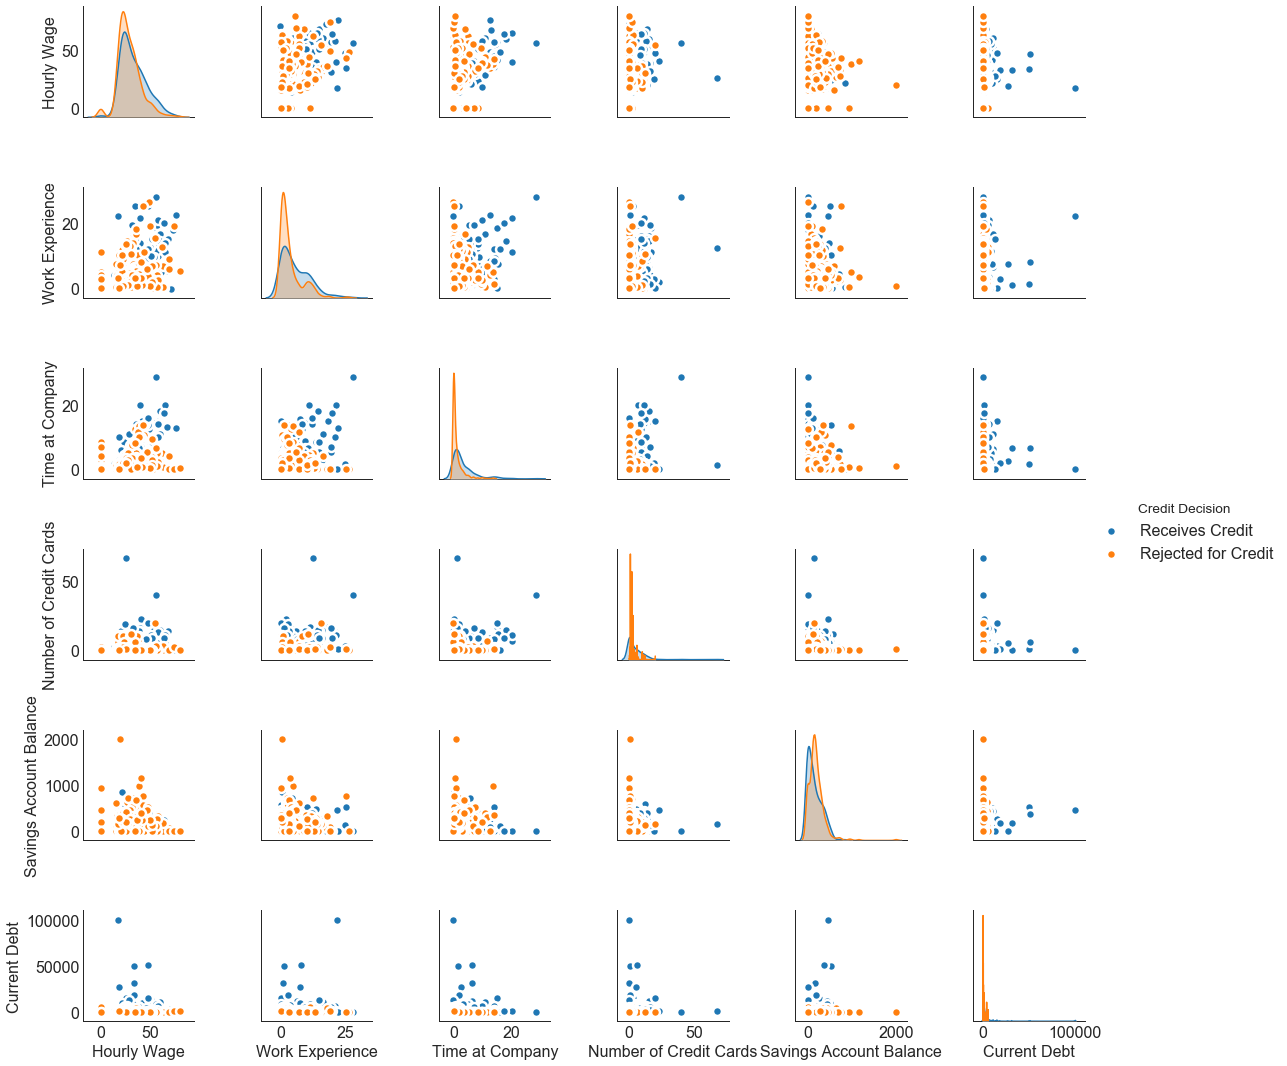

In [192]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(credit, kind="scatter", hue="Credit Decision", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

## Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

## T-Tests ##

I ran four two-sided t-tests using the **Credit Decision** in each t-test. The other continuous variables included whether the applicant, was male or female, owned a home, had a checking account, and had a savings account.

The first t-test between the applicant's sex and the credit decision had a **t-statistic = 5.45** and a **p-value = 6.01e-08**. This is significant as the statistic is high and the p-value is low. This would normally lead me to believe there was a correlation between the applicant's gender and the credit decision. However, more research would need to be done. There were a considerably larger number of females vs. males applying for credit. The percent of females approved for credit out of the total number of females that applied is actually lower than that of the males. Approximately 44% of females were approved for credit and 46% of males.

The second test included whether the applicant owned a home and his/her credit decision. This had a **t-statistic = 2.92** and a **p-value = 0.004**. This second test indicated a significant correlation between owning a home and being approved for credit. Going back and looking at the raw data, it appears obvious that there is a cause and effect. Far more home owners were approved for credit than those that did not own a home. 

Next was a test with the status of the applicant having a checking account or not and the credit decision. This had a **t-statistic = -0.65** and a **p-value = 0.52**. The t-statistic here were very low and the p-value very high. The indication is a lack of significance between these two factors.

Finally, the last was the savings account status and the credit decision. Those result included a **t-statistic = 0.49** and a **p-value = 0.63**. Again, here the t-statistic is low and the p-value high and would lead me to believe there is little to no significance between savings account status and credit decisions. 
